In [1]:
"""Decision tree algorithms are more interpretable than other classes of algorithms,
as a human researcher can track down the various decisions made by the program by analysing the data.
It is therefore possible to have an easy understanding of the factors that ended up being most determinant
on the final classification. Think eg. to the feature importance scores in the RandomForest methods."""

'Decision tree algorithms are more interpretable than other classes of algorithms,\nas a human researcher can track down the various decisions made by the program by analysing the data.\nIt is therefore possible to have an easy understanding of the factors that ended up being most determinant\non the final classification. Think eg. to the feature importance scores in the RandomForest methods.'

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ("s", "x", "o", "^", "v")
    colors = "red blue lightgreen gray cyan".split()
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        print("Label:", cl)
        plt.scatter(x=X[y == cl, 0], y=X[y==cl, 1],
                   alpha=0.8, c=colors[idx], marker=markers[idx], label=cl,
                   edgecolor="black")
        # highlight the test samples
        if test_idx:
            # Plot all samples
            X_test, y_test = X[test_idx, :], y[test_idx]
            plt.scatter(X_test[:, 0], X_test[:, 1], c="", edgecolor="black", alpha=1.0,
                       linewidth=1, marker="o", s=100, label="test set")
        else:
            pass
        continue
        
    return

In [3]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,  # Leave 30% for testing
                                                    random_state=1,
                                                    # Statically determined for reproducibility
                                                    stratify=y)
                                                    # Ensure that the percentages in y are roughly replicated
                                                    # in the train and test dataset. This corrects for
                                                    # imbalanced populations.

# Verify that the proportions of class labels have been maintained in the train/test splits

print("Label counts in y:", np.bincount(y))
print("Label counts in y_train:", np.bincount(y_train))
print("Label counts in y_test:", np.bincount(y_test))

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
# IMPORTANT! Use the same scaling parameters for train and test to make them comparable!
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

Label counts in y: [50 50 50]
Label counts in y_train: [35 35 35]
Label counts in y_test: [15 15 15]


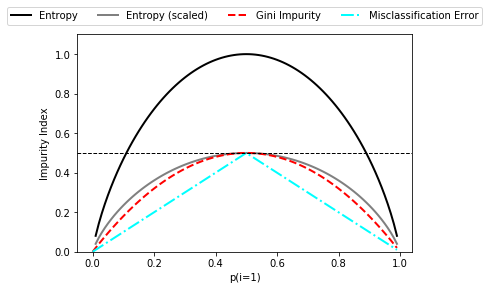

In [4]:
## Here we are discussing a simple model of splitting a case of 80 samples, 40 for class I, 40 for class II
## A: [(40, 40)]  -> [[(10, 30)], [(30, 10)]]  # Very impure, neither class is well segregated
## B: [(40, 40)]  -> [[(20, 40)], [(20, 0)]]  # Significantly purer, now one the leaf nodes contains only
## members of class I.


def gini(p):
    """First of the measures of impurity, based on the Gini coefficient. The higher
    the result, the more the different classes are admixed (ie more information is retained)"""
    
    return (p) * (1 - (p)) + (1 - p) * (1 - (1-p))


def entropy(p):
    """Second of the measures of impurity, based on entropy. Like for Gini, the higher
    the result, the more the different classes are admixed (ie more information is retained)"""
    
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])


x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p!= 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                         ["Entropy", "Entropy (scaled)", "Gini Impurity", "Misclassification Error"],
                         ["-", "-", "--", "-."],
                         ["black", "gray", "red", "cyan"]):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color="k", linestyle="--")
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel("Impurity Index")
plt.show()
    



Label: 0
Label: 1
Label: 2


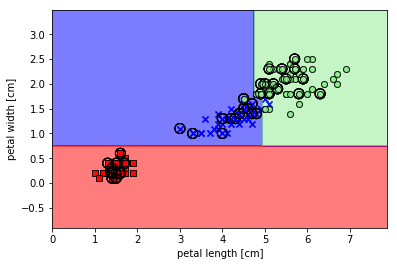

In [6]:
## Now that we have visualised the impurity measures, we can shift to try to build our first decision tree.

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="gini",
                             max_depth=4,
                             random_state=1)

tree.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal width [cm]")
# plt.legend(loc=2)
plt.show()

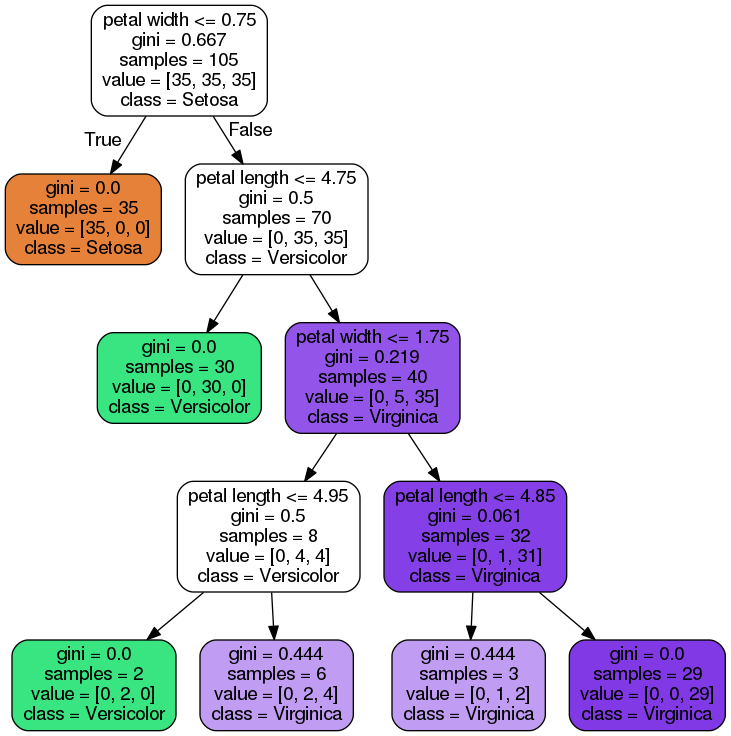

In [8]:
## Now we can visualise the contents of the decision tree using pydotplus

from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True,
                           rounded=True,
                           class_names=["Setosa", "Versicolor", "Virginica"],
                          feature_names=["petal length", "petal width"],
                          out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png("/tmp/tree.png")

from IPython.display import Image
Image(filename="/tmp/tree.png")

Label: 0
Label: 1
Label: 2


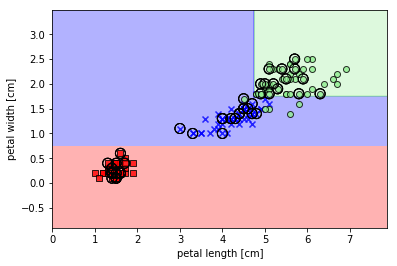

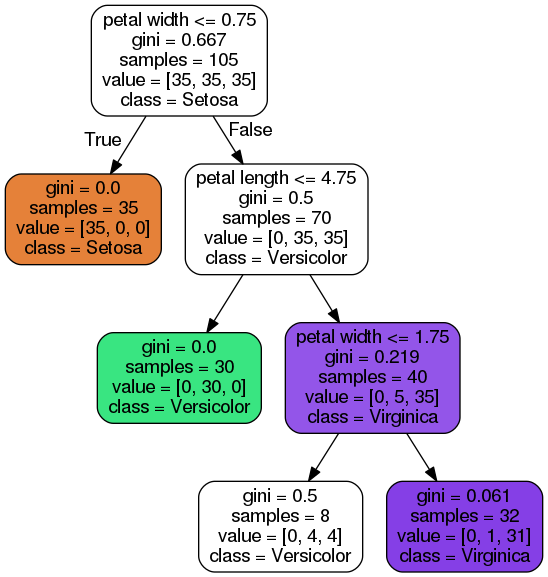

In [9]:
## Let's see what happens if we reduce the maximum depth to three ...

tree3 = DecisionTreeClassifier(criterion="gini",
                             max_depth=3,
                             random_state=1)

tree3.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=tree3, test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal width [cm]")
# plt.legend(loc=2)
plt.show()
dot_data = export_graphviz(tree3,
                           filled=True,
                           rounded=True,
                           class_names=["Setosa", "Versicolor", "Virginica"],
                          feature_names=["petal length", "petal width"],
                          out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png("/tmp/tree3.png")

from IPython.display import Image
Image(filename="/tmp/tree3.png")


Label: 0
Label: 1
Label: 2


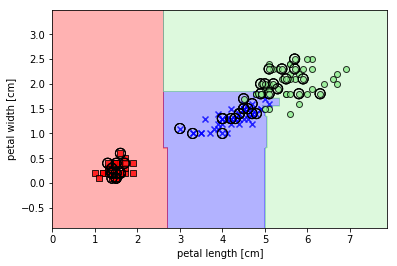

In [10]:
## Now let's try with RandomForest

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion="gini",
                               n_estimators=25,
                               random_state=1,
                               n_jobs=2)

forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105,150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal width [cm]")
plt.show()


Label: 0
Label: 1
Label: 2


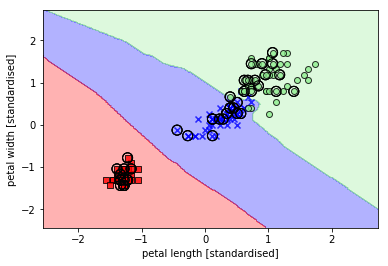

In [12]:
## Finally, K-nearest neighbours is a non-parametric method.
## It relies on memorising *all* of the training data, and then use a distance metric to calculate the
## nearest K-neighbours of a new data point vs. the training data.
## The sample then gets assigned by majority vote.

## Advantages: no presupposition on the shape of the distribution; whether it is planes, rectangles, etc., 
## this algorithm will not be fuzzed
## Also, very simple to understand
## Disadvantages: probably sensitive to very noisy datasets, and it will provide very little insight on the
## data itself (whereas for example decision trees above allow the experimenter to see clearly that petal
## length is a perfect discriminator of Setosa samples vs. the other two species).
## Moreover, this algorithm will start exhibiting problems in terms of memory and speed of space exploration
## very, very quickly

## Now we will try our hand on KNN using the classic Euclidean distance

from sklearn.neighbors import KNeighborsClassifier

## The Minkowski distance is a generalisation of Euclidean distance
## See https://en.wikipedia.org/wiki/Minkowski_distance
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric="minkowski")
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))
plt.xlabel("petal length [standardised]")
plt.ylabel("petal width [standardised]")
plt.show()

## As can be observed in the plot, the boiundaries are *very* noisy, not at all like the linear boundaries 
## we observed in previous cases. On the other hand, the model probably has a better discrimination for
## problematic samples such as those at the touching of the versicolor and virginica species.